In [1]:
from google.colab import files
uploaded = files.upload()

Saving covid_19_clean_complete.csv to covid_19_clean_complete.csv


In [2]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_csv("covid_19_clean_complete.csv", delimiter=",",parse_dates=['Date'])
df.groupby(['Country/Region']).sum()
a = df['Country/Region']
print(a)
df.groupby(['Confirmed']).sum()

b = df['Confirmed']
print(b)
# date = [elem for elem in df['Date']]
# values = [elem for elem in df['Confirmed']]
# plt.xticks(range(0,len(date)),rotation=45)
# plt.plot(country, values)
df = pd.read_csv("covid_19_clean_complete.csv")
df.tail(5)
c= df['Date']
print(c)


#df['Date'] = pd.to_datetime(df['Date'])
#df['Dates'] = df['Date'].apply(lambda x:x.strftime('%B'))
#p = df.groupby('Dates')
#print(p)

df.head(10)

0                  Afghanistan
1                      Albania
2                      Algeria
3                      Andorra
4                       Angola
                 ...          
32060    Sao Tome and Principe
32061                    Yemen
32062                  Comoros
32063               Tajikistan
32064                  Lesotho
Name: Country/Region, Length: 32065, dtype: object
0           0
1           0
2           0
3           0
4           0
         ... 
32060     251
32061     197
32062      34
32063    2350
32064       1
Name: Confirmed, Length: 32065, dtype: int64
0        1/22/20
1        1/22/20
2        1/22/20
3        1/22/20
4        1/22/20
          ...   
32060    5/21/20
32061    5/21/20
32062    5/21/20
32063    5/21/20
32064    5/21/20
Name: Date, Length: 32065, dtype: object


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.0000,65.0000,1/22/20,0,0,0
1,NaN,Albania,41.1533,20.1683,1/22/20,0,0,0
2,NaN,Algeria,28.0339,1.6596,1/22/20,0,0,0
3,NaN,Andorra,42.5063,1.5218,1/22/20,0,0,0
4,NaN,Angola,-11.2027,17.8739,1/22/20,0,0,0
5,NaN,Antigua and Barbuda,17.0608,-61.7964,1/22/20,0,0,0
6,NaN,Argentina,-38.4161,-63.6167,1/22/20,0,0,0
7,NaN,Armenia,40.0691,45.0382,1/22/20,0,0,0
8,Australian Capital Territory,Australia,-35.4735,149.0124,1/22/20,0,0,0
9,New South Wales,Australia,-33.8688,151.2093,1/22/20,0,0,0


In [4]:
sns.set(palette = 'Set1',style='darkgrid')
#Function for making a time serie on a designated country and plotting the rolled mean and standard 
def roll(country,case='Recovered'):
    ts=df.loc[(df['Country/Region']==country)]  
    ts=ts[['Date',case]]
    ts=ts.set_index('Date')
    ts.astype('int64')
    a=len(ts.loc[(ts['Recovered']>=10)])
    ts=ts[-a:]
    return (ts.rolling(window=4,center=False).mean().dropna())


def rollPlot(country, case='Recovered'):
    ts=df.loc[(df['Country/Region']==country)]  
    ts=ts[['Date',case]]
    ts=ts.set_index('Date')
    ts.astype('int64')
    a=len(ts.loc[(ts['Recovered']>=10)])
    ts=ts[-a:]
    plt.figure(figsize=(16,6))
    plt.plot(ts.rolling(window=7,center=False).mean().dropna(),label='Rolling Mean')
    plt.plot(ts[case], label='Recovered')
    plt.plot(ts.rolling(window=7,center=False).std(),label='Rolling std')
    #plt.plot('Confirmed', label='First Line')
    plt.legend()
    plt.title('Cases distribution in %s with rolling mean and standard' %country)
    plt.xticks([])

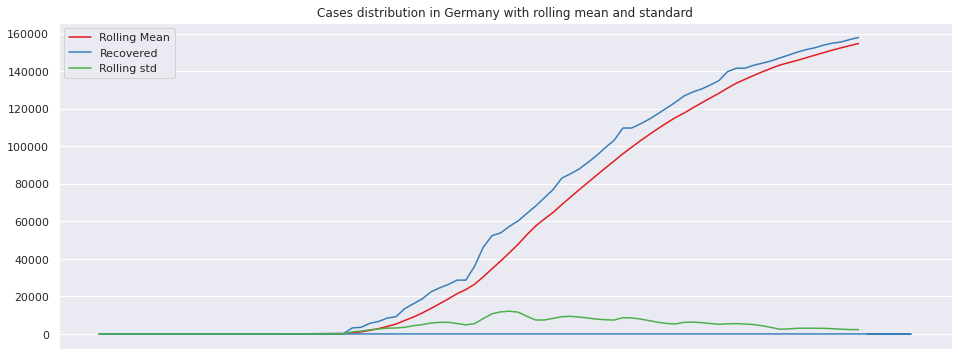

In [5]:
tsC1=roll('Germany')
rollPlot('Germany')

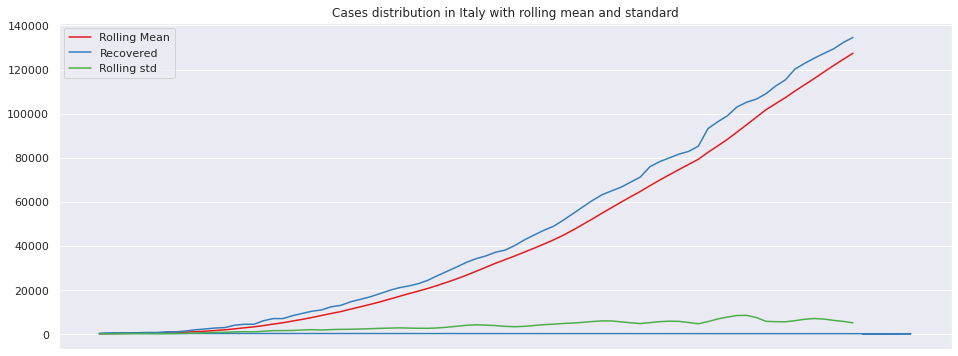

In [6]:
tsC2=roll('Italy')
rollPlot('Italy')

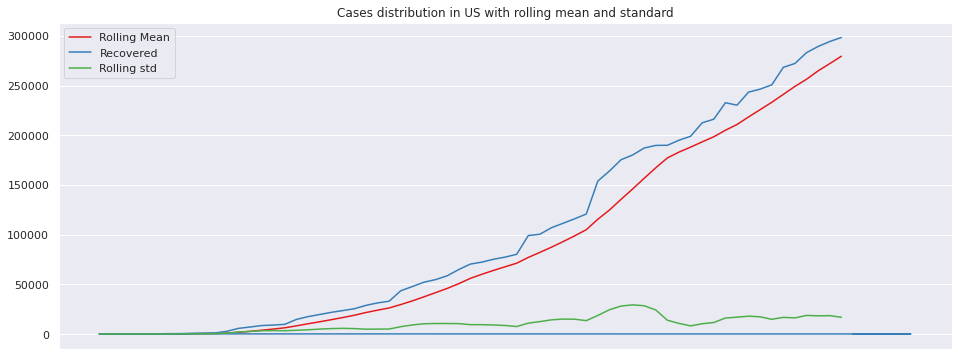

In [7]:
tsC3=roll('US')
rollPlot('US')

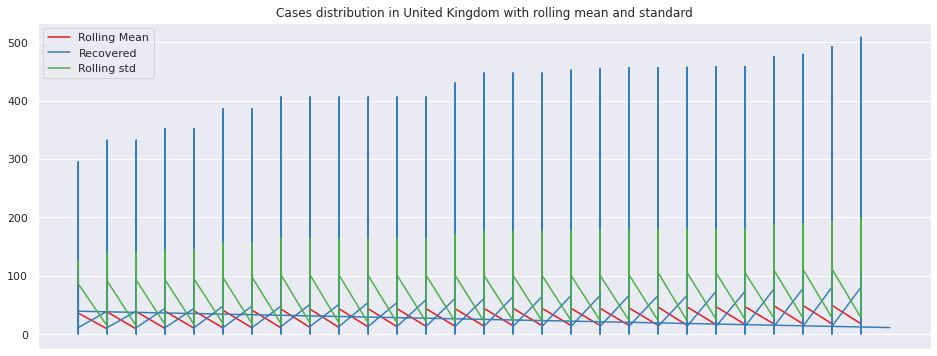

In [8]:
tsC4=roll('United Kingdom')
rollPlot('United Kingdom')

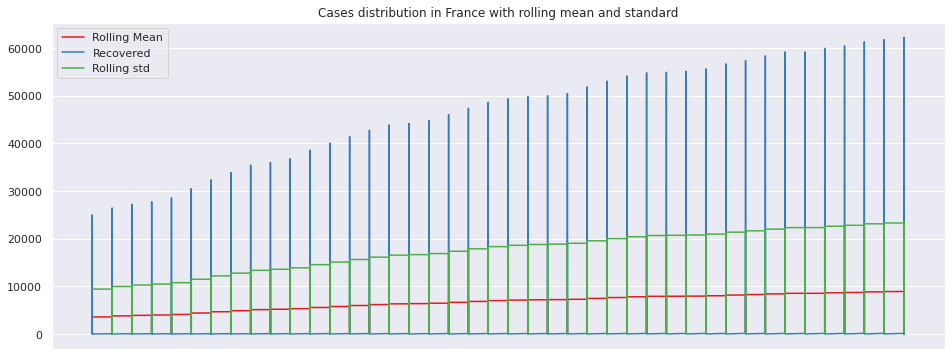

In [9]:
tsC5=roll('France')
rollPlot('France')

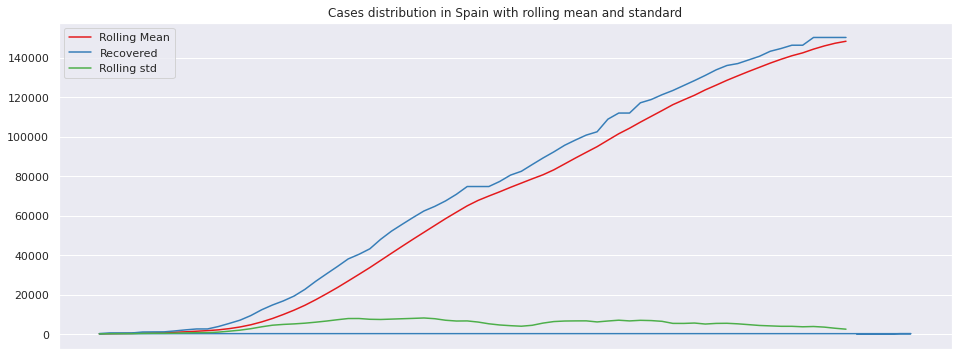

In [10]:
tsC6=roll('Spain')
rollPlot('Spain')

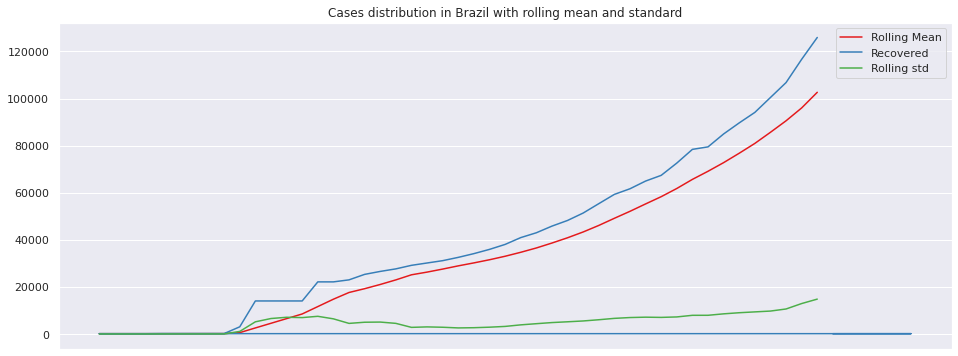

In [11]:
tsC7=roll('Brazil')
rollPlot('Brazil')

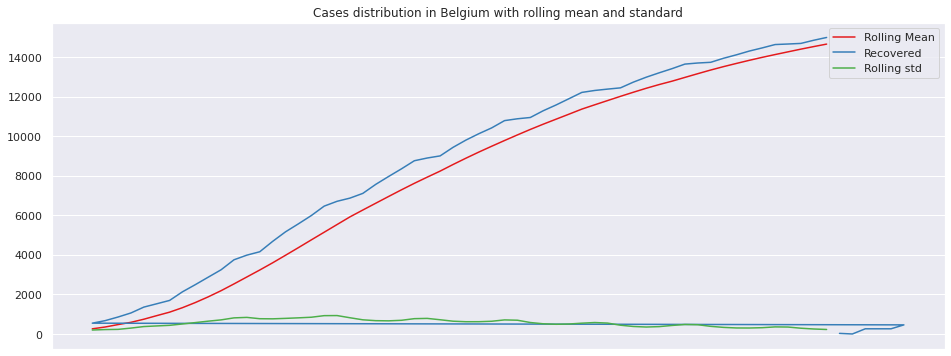

In [12]:
tsC8=roll('Belgium')
rollPlot('Belgium')

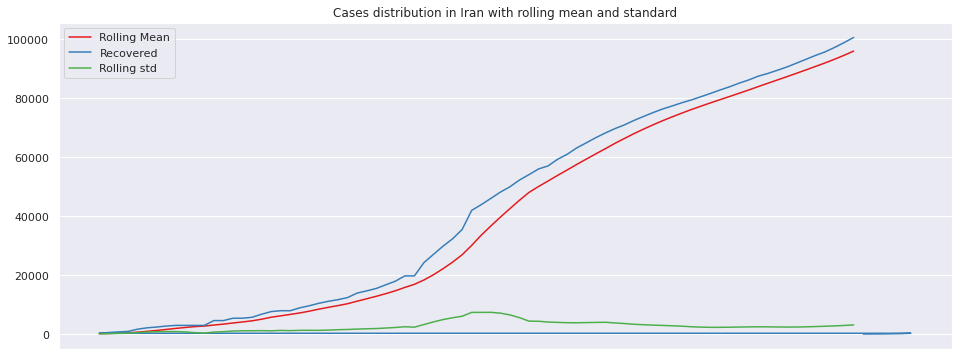

In [13]:
tsC9=roll('Iran')
rollPlot('Iran')

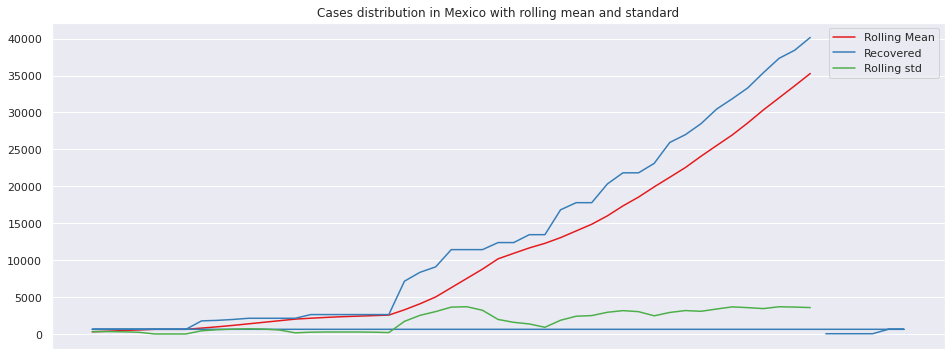

In [14]:
tsC10=roll('Mexico')
rollPlot('Mexico')

In [15]:

df = pd.read_csv("covid_19_clean_complete.csv", delimiter=",")
train_data, test_data= np.split(df, [int(.75 *len(df))])

In [16]:
#test['Date'] = pd.to_datetime(test['Date'])
#train['Date'] = pd.to_datetime(train['Date'])
train_data = train_data.set_index(['Date'])
test_data = test_data.set_index(['Date'])

#data['Date'] = pd.to_datetime(data['Date'])

#data.set_index(['Date', 'month'], inplace=True)

In [17]:
def create_features(df,label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['Date'] = df.index
    #df['hour'] = df['Dates'].dt.hour
    df['dayofweek'] = df['Date'].str.replace('dayofweek','')
    #df['quarter'] = df['Dates'].dt.quarter
    df['month'] = df['Date'].str.replace('month','')
    df['year'] = df['Date'].str.replace('year','')
    df['dayofyear'] = df['Date'].str.replace('dayofyear','')
    df['dayofmonth'] = df['Date'].str.replace('dayofmonth','')
    df['weekofyear'] = df['Date'].str.replace('weekofyear','')
    
    X = df[['dayofweek','month','year',
           'dayofyear','dayofmonth','weekofyear']]
   
    return X

In [18]:
train_features=pd.DataFrame(create_features(train_data))
test_features=pd.DataFrame(create_features(test_data))
features_and_target_train = pd.concat([train_data,train_features], axis=1)
features_and_target_test = pd.concat([test_data,test_features], axis=1)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def FunLabelEncoder(df):
    for c in df.columns:
        if df.dtypes[c] == object:
            le.fit(df[c].astype(str))
            df[c] = le.transform(df[c].astype(str))
    return df
features_and_target_train= FunLabelEncoder(features_and_target_train)

In [19]:
x_train= features_and_target_train[['Country/Region','month' , 'weekofyear']]
y1 = features_and_target_train[['Deaths']]
x_test = features_and_target_test[['Country/Region', 'month' , 'weekofyear']]

In [20]:
from statsmodels.tools.eval_measures import rmse, meanabs
from sklearn.metrics import mean_squared_error,mean_absolute_error

Predicted values : [150767.12711794 152053.40208614 153432.2137884  154816.46529638
 156273.89187432 157826.71146623]
                             ARIMA Model Results                              
Dep. Variable:           D2.Recovered   No. Observations:                   83
Model:                 ARIMA(5, 2, 2)   Log Likelihood                -606.251
Method:                       css-mle   S.D. of innovations            349.943
Date:                Mon, 13 Jul 2020   AIC                           1230.502
Time:                        20:42:31   BIC                           1252.272
Sample:                    02-23-2020   HQIC                          1239.248
                         - 05-15-2020                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 17.0042     36.568      0.465      0.643     -54.668  

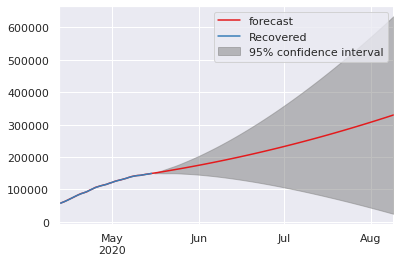

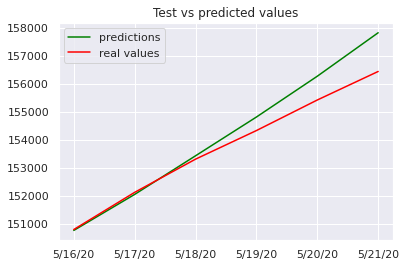

In [21]:

#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.94)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.6), end=int(len(ts) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(tsC1)
prediction=arima(train,test)

Predicted values : [126659.10429666 129555.16036082 132813.25481494]
                             ARIMA Model Results                              
Dep. Variable:           D2.Recovered   No. Observations:                   77
Model:                 ARIMA(4, 2, 4)   Log Likelihood                -519.482
Method:                       css-mle   S.D. of innovations            189.900
Date:                Mon, 13 Jul 2020   AIC                           1058.963
Time:                        20:44:26   BIC                           1082.401
Sample:                    03-03-2020   HQIC                          1068.338
                         - 05-18-2020                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 45.6827      1.929     23.679      0.000      41.901      49.464
ar.L1.D2.Recovered     0.3523      0.1

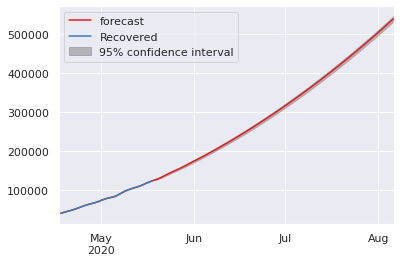

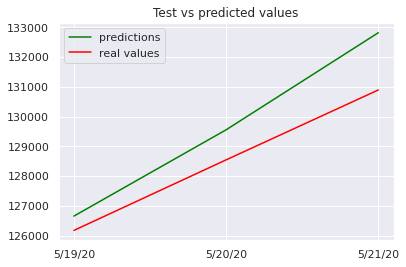

In [23]:

#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.97)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.6), end=int(len(ts) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(tsC2)
prediction=arima(train,test)

Predicted values : [292837.2572139]
                             ARIMA Model Results                              
Dep. Variable:           D2.Recovered   No. Observations:                   65
Model:                 ARIMA(1, 2, 5)   Log Likelihood                -559.129
Method:                       css-mle   S.D. of innovations           1208.560
Date:                Mon, 13 Jul 2020   AIC                           1134.259
Time:                        20:46:28   BIC                           1151.654
Sample:                    03-17-2020   HQIC                          1141.122
                         - 05-20-2020                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                147.4898     26.432      5.580      0.000      95.684     199.296
ar.L1.D2.Recovered    -0.6623      0.285     -2.322      0.024      -1.

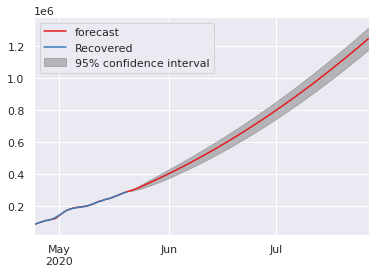

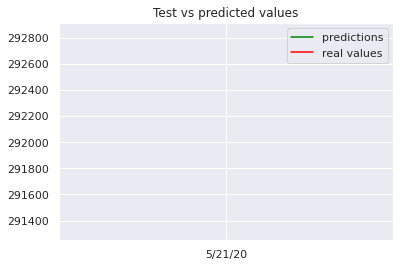

In [25]:

#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.99)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.6), end=int(len(ts) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(tsC3)
prediction=arima(train,test)

Predicted values : [-32.67204857 -33.65755255 -25.7467706    8.70308574  93.51450044
 149.29447412 202.93103101 209.99606843 179.57938137 121.34548848
  48.87098212  -8.83042418 -38.06979967 -27.13639415  19.49539428
  86.64305478 153.54719595 198.31204002 207.27490596 177.51516455
 118.69870866  49.67224996  -7.68121965 -35.13042692 -24.13141038]
                              ARMA Model Results                              
Dep. Variable:              Recovered   No. Observations:                  281
Model:                     ARMA(5, 5)   Log Likelihood               -1216.394
Method:                       css-mle   S.D. of innovations             17.495
Date:                Mon, 13 Jul 2020   AIC                           2456.787
Time:                        20:49:43   BIC                           2500.447
Sample:                             0   HQIC                          2474.297
                                                                              
                  

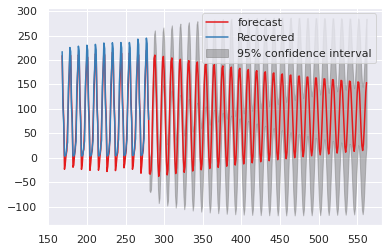

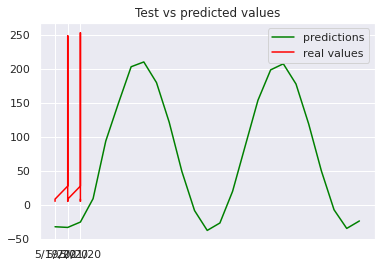

In [27]:

#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.92)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.6), end=int(len(ts) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(tsC4)
prediction=arima(train,test)

Predicted values : [-3994.95247023  4133.30132981  4686.14701903  6793.38860886
 14055.40600656  9154.13185975  9093.95721969  9083.75063789
   840.05368499  3058.76000193  2592.93034233  -105.52843628
  7313.39076732  6756.48176268  7089.46389669 12138.85096546
  6663.81838482  6528.73846817  7238.55936108   960.20371271
  4282.26479259  4691.46548054  2414.9714115   8684.87098501
  7198.41536329  6494.19102775 10363.14902006  5143.46322584]
                             ARIMA Model Results                              
Dep. Variable:            D.Recovered   No. Observations:                  426
Model:                 ARIMA(4, 1, 4)   Log Likelihood               -3902.088
Method:                       css-mle   S.D. of innovations           2230.481
Date:                Mon, 13 Jul 2020   AIC                           7824.176
Time:                        20:58:59   BIC                           7864.720
Sample:                             1   HQIC                          7840.191


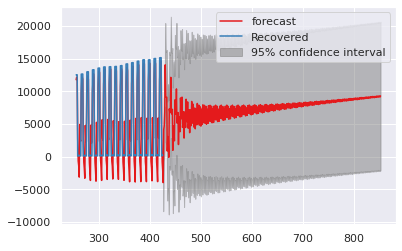

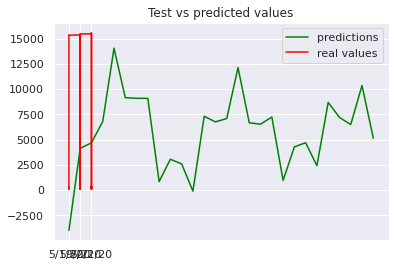

In [33]:

#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.94)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.6), end=int(len(ts) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(tsC5)
prediction=arima(train,test)

Predicted values : [146452.88740714 147687.28033286 148784.99776751 150124.81058908]
                             ARIMA Model Results                              
Dep. Variable:           D2.Recovered   No. Observations:                   67
Model:                 ARIMA(4, 2, 3)   Log Likelihood                -474.663
Method:                       css-mle   S.D. of innovations            273.529
Date:                Mon, 13 Jul 2020   AIC                            967.325
Time:                        21:01:08   BIC                            987.167
Sample:                    03-12-2020   HQIC                           975.177
                         - 05-17-2020                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 17.4743     46.965      0.372      0.711     -74.576     109.525
ar.L1.D2.Recovered    

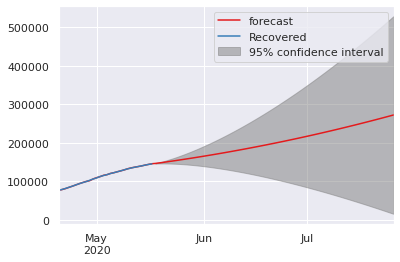

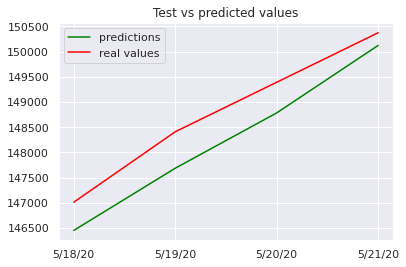

In [35]:

#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.95)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.6), end=int(len(ts) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(tsC6)
prediction=arima(train,test)

Predicted values : [111410.88829763]
                             ARIMA Model Results                              
Dep. Variable:           D2.Recovered   No. Observations:                   47
Model:                 ARIMA(0, 2, 0)   Log Likelihood                -368.537
Method:                           css   S.D. of innovations            615.401
Date:                Mon, 13 Jul 2020   AIC                            741.074
Time:                        21:30:35   BIC                            744.774
Sample:                    04-04-2020   HQIC                           742.466
                         - 05-20-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        143.6383     89.766      1.600      0.116     -32.299     319.575
Error Values
Mean Value : Recovered    112474.0
dtype: float64
MAE Value : [1063.11170237]
RMS

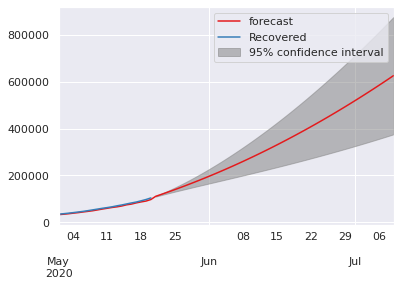

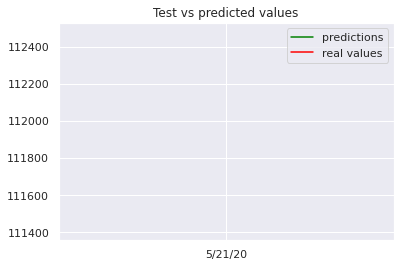

In [39]:

#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.99)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.6), end=int(len(ts) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(tsC7)
prediction=arima(train,test)

Predicted values : [14553.08505679 14707.32869734 14842.16510445 14974.50021109]
                             ARIMA Model Results                              
Dep. Variable:           D2.Recovered   No. Observations:                   55
Model:                 ARIMA(2, 2, 5)   Log Likelihood                -257.874
Method:                       css-mle   S.D. of innovations             24.034
Date:                Mon, 13 Jul 2020   AIC                            533.749
Time:                        21:32:57   BIC                            551.815
Sample:                    03-24-2020   HQIC                           540.735
                         - 05-17-2020                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.1990      4.071      0.540      0.592      -5.780      10.178
ar.L1.D2.Recovered     1.2

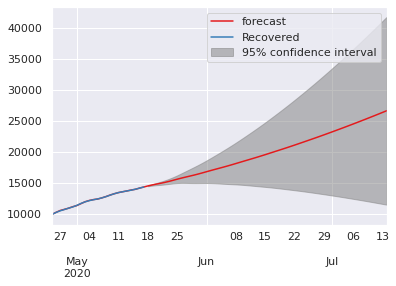

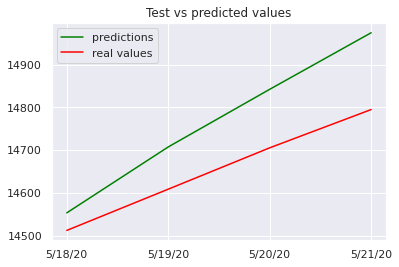

In [41]:

#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.94)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.6), end=int(len(ts) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(tsC8)
prediction=arima(train,test)

Predicted values : [92391.88690188 93602.5975435  94782.70185402 95962.75129486
 97154.17055767]
                             ARIMA Model Results                              
Dep. Variable:           D2.Recovered   No. Observations:                   76
Model:                 ARIMA(4, 2, 1)   Log Likelihood                -509.064
Method:                       css-mle   S.D. of innovations                nan
Date:                Mon, 13 Jul 2020   AIC                           1032.127
Time:                        21:33:55   BIC                           1048.442
Sample:                    03-02-2020   HQIC                          1038.648
                         - 05-16-2020                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -5.1501     35.939     -0.143      0.886     -75.589      65.289
ar.L1.D2.R

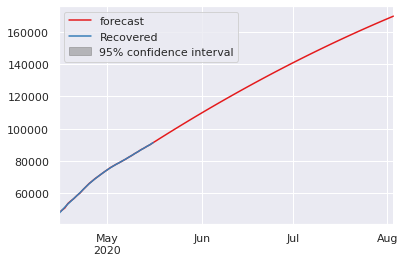

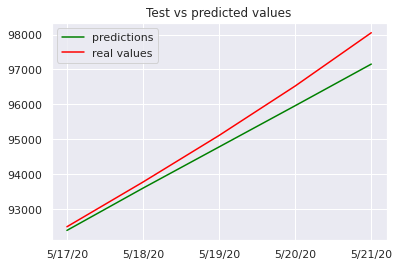

In [42]:

#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.94)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.6), end=int(len(ts) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(tsC9)
prediction=arima(train,test)

Predicted values : [34482.38809603 36346.43377258 38250.8939038 ]
                             ARIMA Model Results                              
Dep. Variable:           D2.Recovered   No. Observations:                   45
Model:                 ARIMA(0, 2, 4)   Log Likelihood                -311.758
Method:                       css-mle   S.D. of innovations            220.878
Date:                Mon, 13 Jul 2020   AIC                            635.517
Time:                        21:35:05   BIC                            646.357
Sample:                    04-04-2020   HQIC                           639.558
                         - 05-18-2020                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 40.4145      8.533      4.736      0.000      23.689      57.140
ma.L1.D2.Recovered    -0.0988      0.105 

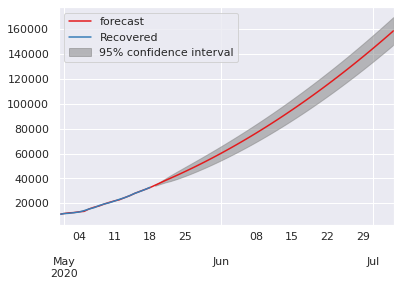

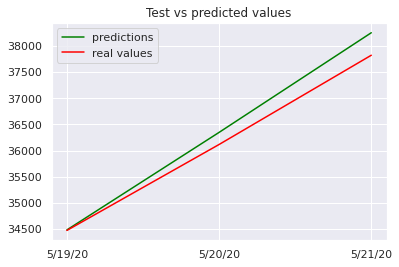

In [43]:

#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.94)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.6), end=int(len(ts) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(tsC10)
prediction=arima(train,test)

In [ ]:
#Checking for similarity(Trend) between Germany and Italy in Death cases using number of predicted values from model result

In [ ]:

from scipy.special import rel_entr
# defining distributions
Germany = [7972.36959755, 8062.7594309,  8134.85335376, 8202.57606246, 8274.24853297, 8368.85306069]
Italy = [31473.31708024, 31824.28657176, 32179.43901308, 32538.77440418,
 32902.29274508, 33269.99403576]
# calculating (Germany || Italy)
kl_Germany_Italy = rel_entr(Germany, Italy)
print('KL(Germany || Italy): %.3f nats' % sum(kl_Germany_Italy))
# calculating (Italy || Germany)
kl_Italy_Germany = rel_entr(Italy,Germany)
print('KL(Italy || Germany): %.3f nats' % sum(kl_Italy_Germany))

KL(Germany || Italy): -67479.016 nats
KL(Italy || Germany): 267337.231 nats


In [ ]:
#Hence,Kl divergence satisfies the condition that KL(Germany || Italy)!=KL(Italy || Germany)


In [ ]:

from scipy.spatial.distance import jensenshannon
from numpy import asarray
# defining distributions
Germany = asarray([7972.36959755, 8062.7594309,  8134.85335376, 8202.57606246, 8274.24853297, 8368.85306069])
Italy = asarray([31473.31708024, 31824.28657176, 32179.43901308, 32538.77440418,
 32902.29274508, 33269.99403576])
# calculating (Germany || Italy)
JS_Germany_Italy = jensenshannon(Germany, Italy,base=2)
print('JS(Germany || Italy): %.3f nats' % JS_Germany_Italy)
# calculating (Italy || Germany)
JS_Italy_Germany = jensenshannon(Italy,Germany,base=2)
print('JS(Italy || Germany): %.3f nats' % JS_Italy_Germany)

JS(Germany || Italy): 0.001 nats
JS(Italy || Germany): 0.001 nats


In [ ]:
#Hence,JS divergence satisfies the condition that JS(Germany || Italy)==JS(Italy || Germany)


In [ ]:
from scipy import stats
stats.spearmanr([7972.36959755, 8062.7594309,  8134.85335376, 8202.57606246, 8274.24853297, 8368.85306069], [31473.31708024, 31824.28657176, 32179.43901308, 32538.77440418,
 32902.29274508, 33269.99403576])

np.random.seed(7972)
x2n = np.random.randn(100, 2)
y2n = np.random.randn(100, 2)
stats.spearmanr(x2n)

SpearmanrResult(correlation=0.1438943894389439, pvalue=0.15320623761722527)

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

#df = pd.read_csv('synchrony_sample.csv')
overall_pearson_r = df.corr().iloc[0,1]
print(f"Pandas computed Pearson r: {overall_pearson_r}")
# out: Pandas computed Pearson r: 0.2058774513561943
#df.loc[(df['Country/Region']==country)]
r, p = stats.pearsonr(df.loc[(Country/Region['Germany'])].dropna(), df.loc[(df['Country/Region(Italy)'])].dropna())
#r, p = stats.pearsonr(df.dropna()['Confirmed'], df.dropna()['Recovered'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")
# out: Scipy computed Pearson r: 0.20587745135619354 and p-value: 3.7902989479463397e-51

# Compute rolling window synchrony
f,ax=plt.subplots(figsize=(7,3))
df.rolling(window=30,center=True).median().plot(ax=ax)
ax.set(xlabel='Time',ylabel='Pearson r')
ax.set(title=f"Overall Pearson r = {np.round(overall_pearson_r,2)}");

Pandas computed Pearson r: -0.1282098089914872


NameError: ignored